In [2]:
import os
import numpy as np
import tensorflow as tf
import shutil

In [ ]:
TRAIN_DIR = "./data"

BRIGHT_PIXEL_THRESHOLD = 245  # pixel gần trắng
BRIGHT_RATIO_THRESHOLD = 0.30  # >30% pixel trắng => chói

In [3]:
import cv2
import numpy as np

def is_very_bright(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    bright_pixels = gray >= BRIGHT_PIXEL_THRESHOLD
    bright_ratio = np.sum(bright_pixels) / gray.size

    return bright_ratio > BRIGHT_RATIO_THRESHOLD


In [6]:
report = {}

for cls in os.listdir(TRAIN_DIR):
    cls_path = os.path.join(TRAIN_DIR, cls)
    if not os.path.isdir(cls_path):
        continue

    bad_count = 0
    total = 0

    for img_name in os.listdir(cls_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        total += 1

        if is_very_bright(img):   # truyền ảnh
            bad_count += 1

    report[cls] = (bad_count, total)
    print(f"{cls}: {bad_count}/{total} ảnh chói")


Apple___Apple_scab: 0/2016 ảnh chói
Apple___Black_rot: 0/1987 ảnh chói
Apple___Cedar_apple_rust: 200/1760 ảnh chói
Apple___healthy: 0/2008 ảnh chói
Blueberry___healthy: 173/1816 ảnh chói
Cherry_(including_sour)___healthy: 0/1826 ảnh chói
Cherry_(including_sour)___Powdery_mildew: 0/1683 ảnh chói
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0/1642 ảnh chói
Corn_(maize)___Common_rust_: 0/1907 ảnh chói
Corn_(maize)___healthy: 0/1859 ảnh chói
Corn_(maize)___Northern_Leaf_Blight: 0/1908 ảnh chói
Grape___Black_rot: 0/1888 ảnh chói
Grape___Esca_(Black_Measles): 0/1920 ảnh chói
Grape___healthy: 0/1692 ảnh chói
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 0/1722 ảnh chói
Orange___Haunglongbing_(Citrus_greening): 0/2010 ảnh chói
Peach___Bacterial_spot: 0/1838 ảnh chói
Peach___healthy: 281/1728 ảnh chói
Pepper,_bell___Bacterial_spot: 0/1913 ảnh chói
Pepper,_bell___healthy: 205/1988 ảnh chói
Potato___Early_blight: 0/1939 ảnh chói
Potato___healthy: 125/1824 ảnh chói
Potato___Late_blight: 0/193

In [7]:
BRIGHT_DIR = "./data/bright_images"
os.makedirs(BRIGHT_DIR, exist_ok=True)

In [8]:
import shutil

moved = 0

for cls in os.listdir(TRAIN_DIR):
    cls_path = os.path.join(TRAIN_DIR, cls)
    if not os.path.isdir(cls_path):
        continue

    out_cls = os.path.join(BRIGHT_DIR, cls)
    os.makedirs(out_cls, exist_ok=True)

    for img_name in os.listdir(cls_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        src = os.path.join(cls_path, img_name)
        img = cv2.imread(src)

        if img is None:
            continue

        if is_very_bright(img):
            dst = os.path.join(out_cls, img_name)

            # tránh trùng tên
            if os.path.exists(dst):
                base, ext = os.path.splitext(img_name)
                dst = os.path.join(out_cls, f"{base}_bright{ext}")

            shutil.move(src, dst)
            moved += 1

print(f"Đã chuyển {moved} ảnh chói")

Đã chuyển 1919 ảnh chói


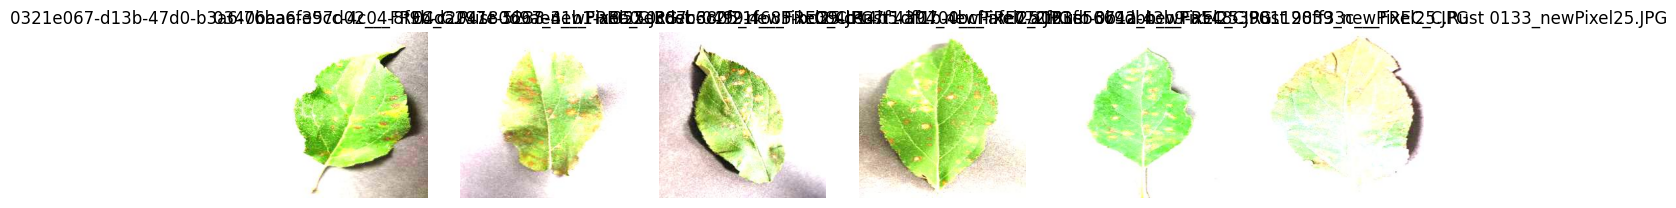

In [9]:
import matplotlib.pyplot as plt

def show_bright_images(cls, max_show=6):
    cls_path = os.path.join(BRIGHT_DIR, cls)
    plt.figure(figsize=(15, 5))

    shown = 0
    for img_name in os.listdir(cls_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, max_show, shown + 1)
        plt.imshow(img_rgb)
        plt.title(img_name)
        plt.axis("off")

        shown += 1
        if shown >= max_show:
            break

    plt.show()

show_bright_images("Apple___Cedar_apple_rust")

In [10]:
def is_medium_bright(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bright_pixels = gray >= BRIGHT_PIXEL_THRESHOLD
    bright_ratio = bright_pixels.sum() / gray.size
    return 0.05 < bright_ratio <= BRIGHT_RATIO_THRESHOLD

In [11]:
def is_blurry(img, thresh=120):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < thresh

In [12]:
def fix_image(img):
    # Giảm chói nhẹ
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = np.clip(l * 0.85, 0, 255).astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
    l = clahe.apply(l)

    lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Sharpen nhẹ cho ảnh mờ
    blur = cv2.GaussianBlur(img, (0,0), sigmaX=1.0)
    img = cv2.addWeighted(img, 1.3, blur, -0.3, 0)

    return img

In [13]:
fixed = 0

for cls in os.listdir(TRAIN_DIR):
    cls_path = os.path.join(TRAIN_DIR, cls)
    if not os.path.isdir(cls_path):
        continue

    for img_name in os.listdir(cls_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # chỉ cần chói vừa HOẶC mờ
        if is_medium_bright(img) or is_blurry(img):
            img = fix_image(img)
            cv2.imwrite(img_path, img)
            fixed += 1

print(f"Đã chỉnh {fixed} ảnh (chói vừa hoặc mờ)")


Đã chỉnh 2265 ảnh (chói vừa hoặc mờ)


In [ ]:
import tensorflow as tf
from tensorflow.keras import preprocessing

train_dir = "./data/train"
valid_dir = "./data/valid"
test_dir  = "./data/test/test"

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    image_size=img_size, 
    batch_size=batch_size
)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir, 
    image_size=img_size, 
    batch_size=batch_size
)
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     test_dir, 
#     image_size=img_size, 
#     batch_size=batch_size
# )

Found 68376 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [15]:
class_names = train_ds.class_names
num_classes = len(class_names)

print("Number of classes:", num_classes)
print("Classes:", class_names)

Number of classes: 38
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_sp

In [16]:
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False # đóng băng các lớp của mô hình gốc

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
   #tf.keras.layer.RandomBrightness(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [ ]:
# Áp dụng tăng cường dữ liệu cho tập huấn luyện
def augment_train(image, label):
    image = data_augmentation(image, training=True)
    return image, label

train_ds_aug = train_ds.map(
    augment_train,
    num_parallel_calls=1
)


In [20]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])


In [21]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 960)            │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,974 (12.42 MB)

 Trainable params: 257,702 (1006.65 KB)

 Non-trainable params: 2,998,272 (11.44 MB)

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-5,
)

In [24]:
history = model.fit(
    train_ds_aug,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[checkpoint, early_stop, reduce_lr]
)
print("Training completed.")

Epoch 1/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1345s 628ms/step - accuracy: 0.6456 - loss: 1.3031 - val_accuracy: 0.8876 - val_loss: 0.3870 - learning_rate: 1.0000e-04
Epoch 2/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1323s 619ms/step - accuracy: 0.8613 - loss: 0.4462 - val_accuracy: 0.9247 - val_loss: 0.2491 - learning_rate: 1.0000e-04
Epoch 3/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1330s 622ms/step - accuracy: 0.9022 - loss: 0.3103 - val_accuracy: 0.9388 - val_loss: 0.1994 - learning_rate: 1.0000e-04
Epoch 4/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1333s 624ms/step - accuracy: 0.9214 - loss: 0.2460 - val_accuracy: 0.9431 - val_loss: 0.1786 - learning_rate: 1.0000e-04
Epoch 5/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1341s 628ms/step - accuracy: 0.9303 - loss: 0.2141 - val_accuracy: 0.9482 - val_loss: 0.1652 - learning_rate: 1.0000e-04
Epoch 6/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1333s 624ms/step - accuracy: 0.9402 - loss: 0.1854 - val_accuracy: 0.9504 - val_loss: 0.1598 - learning_rate: 1.0000e-04
Epoch 7/10
2137/2137 ━

In [ ]:
#load lại model
model = tf.keras.models.load_model("best_model.keras")

Found 3503 images belonging to 38 classes.
110/110 ━━━━━━━━━━━━━━━━━━━━ 68s 623ms/step
Validation Accuracy: 0.9301
Validation F1 Score: 0.9296


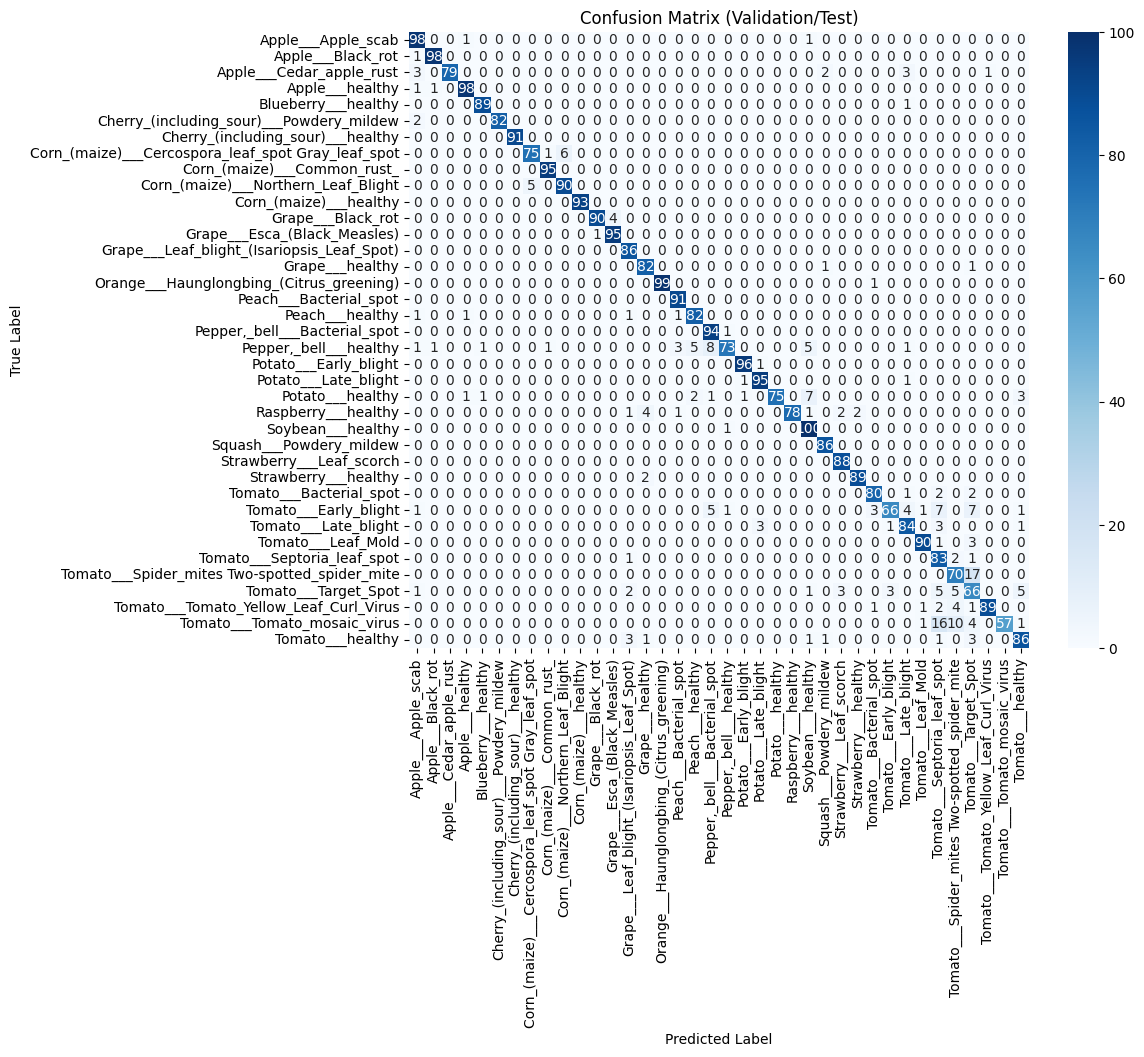

In [13]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import matplotlib.pyplot as plt

# =========================
DATA_DIR = "./valid"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
# =========================
# Tạo validation generator
train_datagen = ImageDataGenerator(validation_split=VAL_SPLIT, preprocessing_function=preprocess_input)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)
Y_true = val_gen.classes
Y_pred_probs = model.predict(val_gen)
Y_pred = np.argmax(Y_pred_probs, axis=1)
# =========================
# Tính accuracy và F1 score
# =========================
acc = accuracy_score(Y_true, Y_pred)
f1 = f1_score(Y_true, Y_pred, average='weighted')
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# =========================
# Ma trận nhầm lẫn
# =========================
class_names = list(val_gen.class_indices.keys())

cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation/Test)")
plt.show()

In [14]:
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(model, img_path, class_names):
    img = load_img(img_path, target_size=img_size)
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)

    preds = model.predict(img)
    idx = np.argmax(preds)
    conf = np.max(preds)

    return class_names[idx], conf

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
Dự đoán: Apple___Cedar_apple_rust (99.89%)


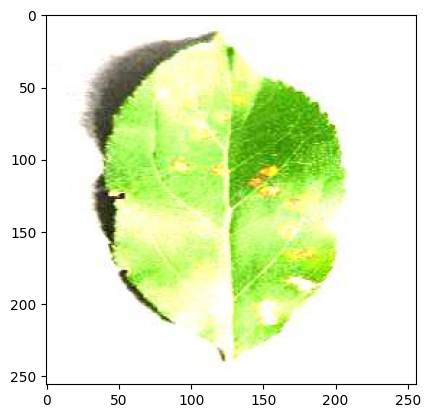

In [ ]:
# Đường dẫn ảnh cần test
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img_path = "./data/test/test/AppleCedarRust1.JPG"
label, conf = predict_image(model, img_path, class_names)
plt.imshow(image.load_img(img_path))
print(f"Dự đoán: {label} ({conf:.2%})")


Dự đoán đúng

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Dự đoán: Apple___Cedar_apple_rust (51.48%)


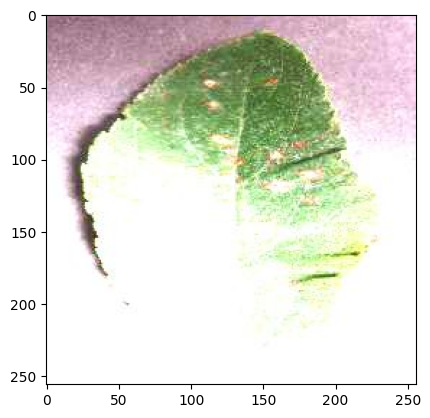

In [ ]:
# Đường dẫn ảnh cần test
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img_path = "./data/bright_images/Apple___Cedar_apple_rust/2ac8d689-f30a-4eee-a856-86c92f8dcbd2___FREC_C.Rust 3952_newPixel25.JPG" #Ảnh quá chói đã được sàng lọc
label, conf = predict_image(model, img_path, class_names)
plt.imshow(image.load_img(img_path))
print(f"Dự đoán: {label} ({conf:.2%})")


Dự đoán đúng

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Dự đoán: Tomato___Septoria_leaf_spot (84.02%)


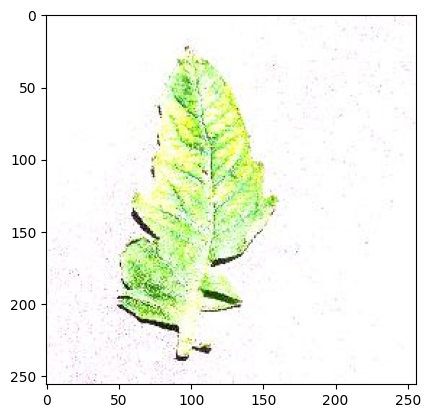

In [17]:
# Đường dẫn ảnh cần test
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img_path = "./data/bright_images/Tomato___Tomato_mosaic_virus/0a7cc59f-b2b0-4201-9c4a-d91eca5c03a3___PSU_CG 2230_newPixel25.JPG"
label, conf = predict_image(model, img_path, class_names)
plt.imshow(image.load_img(img_path))
print(f"Dự đoán: {label} ({conf:.2%})")

Dự đoán sai (đúng loại lá, chưa đúng bệnh)